# Action Recognition @ UCF101  
**Due date: 11:59 pm on Nov. 19, 2019 (Tuesday)**

## Description
---
In this homework, you will be doing action recognition using Recurrent Neural Network (RNN), (Long-Short Term Memory) LSTM in particular. You will be given a dataset called UCF101, which consists of 101 different actions/classes and for each action, there will be 145 samples. We tagged each sample into either training or testing. Each sample is supposed to be a short video, but we sampled 25 frames from each videos to reduce the amount of data. Consequently, a training sample is an image tuple that forms a 3D volume with one dimension encoding *temporal correlation* between frames and a label indicating what action it is.

To tackle this problem, we aim to build a neural network that can not only capture spatial information of each frame but also temporal information between frames. Fortunately, you don't have to do this on your own. RNN — a type of neural network designed to deal with time-series data — is right here for you to use. In particular, you will be using LSTM for this task.

Instead of training an end-to-end neural network from scratch whose computation is prohibitively expensive, we divide this into two steps: feature extraction and modelling. Below are the things you need to implement for this homework:
- **{35 pts} Feature extraction**. Use any of the [pre-trained models](https://pytorch.org/docs/stable/torchvision/models.html) to extract features from each frame. Specifically, we recommend not to use the activations of the last layer as the features tend to be task specific towards the end of the network. 
    **hints**: 
    - A good starting point would be to use a pre-trained VGG16 network, we suggest first fully connected layer `torchvision.models.vgg16` (4096 dim) as features of each video frame. This will result into a 4096x25 matrix for each video. 
    - Normalize your images using `torchvision.transforms` 
    ```
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    prep = transforms.Compose([ transforms.ToTensor(), normalize ])
    prep(img)
    The mean and std. mentioned above is specific to Imagenet data
    
    ```
    More details of image preprocessing in PyTorch can be found at http://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    
- **{35 pts} Modelling**. With the extracted features, build an LSTM network which takes a **dx25** sample as input (where **d** is the dimension of the extracted feature for each frame), and outputs the action label of that sample.
- **{20 pts} Evaluation**. After training your network, you need to evaluate your model with the testing data by computing the prediction accuracy **(5 points)**. The baseline test accuracy for this data is 75%, and **10 points** out of 20 is for achieving test accuracy greater than the baseline. Moreover, you need to compare **(5 points)** the result of your network with that of support vector machine (SVM) (stacking the **dx25** feature matrix to a long vector and train a SVM).
- **{10 pts} Report**. Details regarding the report can be found in the submission section below.

Notice that the size of the raw images is 256x340, whereas your pre-trained model might take **nxn** images as inputs. To solve this problem, instead of resizing the images which unfavorably changes the spatial ratio, we take a better solution: Cropping five **nxn** images, one at the image center and four at the corners and compute the **d**-dim features for each of them, and average these five **d**-dim feature to get a final feature representation for the raw image.
For example, VGG takes 224x224 images as inputs, so we take the five 224x224 croppings of the image, compute 4096-dim VGG features for each of them, and then take the mean of these five 4096-dim vectors to be the representation of the image.

In order to save you computational time, you need to do the classification task only for **the first 25** classes of the whole dataset. The same applies to those who have access to GPUs. **Bonus 10 points for running and reporting on the entire 101 classes.**


## Dataset
Download **dataset** at [UCF101](http://vision.cs.stonybrook.edu/~yangwang/public/UCF101_images.tar)(Image data for each video) and the **annos folder** which has the video labels and the label to class name mapping is included in the assignment folder uploaded. 


UCF101 dataset contains 101 actions and 13,320 videos in total.  

+ `annos/actions.txt`  
  + lists all the actions (`ApplyEyeMakeup`, .., `YoYo`)   
  
+ `annots/videos_labels_subsets.txt`  
  + lists all the videos (`v_000001`, .., `v_013320`)  
  + labels (`1`, .., `101`)  
  + subsets (`1` for train, `2` for test)  

+ `images/`  
  + each folder represents a video
  + the video/folder name to class mapping can be found using `annots/videos_labels_subsets.txt`, for e.g. `v_000001` belongs to class 1 i.e. `ApplyEyeMakeup`
  + each video folder contains 25 frames  



## Some Tutorials
- Good materials for understanding RNN and LSTM
    - http://blog.echen.me
    - http://karpathy.github.io/2015/05/21/rnn-effectiveness/
    - http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Implementing RNN and LSTM with PyTorch
    - [LSTM with PyTorch](http://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#sphx-glr-beginner-nlp-sequence-models-tutorial-py)
    - [RNN with PyTorch](http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

In [0]:
## Import sattements

import numpy as np
import os
import pickle
import random
import requests
import sys
import tarfile
import time
import torch
import torch.nn as nn
import torch.optim as optim

from glob import glob
from PIL import Image
from sklearn import multiclass, svm
from torchvision import transforms as T
from torchvision import models

In [0]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/gdrive/My\ Drive/CV/Singh_Yasha_112970310_hw5/UCF_101/actions.txt /content/gdrive/My\ Drive/CV/Singh_Yasha_112970310_hw5/UCF_101/videos_labels_subsets.txt /content/gdrive/My\ Drive/CV/Singh_Yasha_112970310_hw5/UCF_101/features* /content/.

In [0]:
!ls

actions.txt	 features_1.pkl   features_3.pkl  features_9.pkl
features_0.pkl	 features_21.pkl  features_4.pkl  gdrive
features_10.pkl  features_22.pkl  features_5.pkl  sample_data
features_11.pkl  features_23.pkl  features_6.pkl  videos_labels_subsets.txt
features_12.pkl  features_24.pkl  features_7.pkl
features_13.pkl  features_2.pkl   features_8.pkl


---
---
## **Problem 1.** Feature extraction

In [0]:
"""
For downloading and extracting the given data.
"""

url = 'http://vision.cs.stonybrook.edu/~yangwang/public/UCF101_images.tar'

response = requests.get(url, stream=True)
if response.status_code == 200:
  print("Dataset URI hit successfull!")
  tar_file_name = 'UCF101_images.tar'
  print("Tar file download initiated.")
  with open(tar_file_name, 'wb') as f:
    for chunk in response.iter_content(chunk_size=1024):
      if chunk:
        f.write(chunk)
  print("Tar download successfull!\nExtracting data..")
  tar = tarfile.open(tar_file_name)
  tar.extractall('.')
  stat = os.system('rm '+tar_file_name)
  print("Data extracted successfully and tar file is deleted.")
else:
  print("Failed to fetch dataset.")

Dataset URI hit successfull!
Tar file download initiated.
Tar download successfull!
Extracting data..
Data extracted successfully and tar file is deleted.


In [0]:
"""
Reading the given text files-
1. action.txt
2. video_labels.subsets.txt
"""

## Reading actions.txt
actions = dict()
f = open("actions.txt", "r")
content = f.readlines()
f.close()

for action in content:
  key, sep, action = action.strip().split(" ")
  actions[key] = action

print("Actions in given dataset = {}\n".format(actions))

## Reading video_labels_subset.txt
train_video_titles = list()
train_video_labels = list()
test_video_titles = list()
test_video_labels = list()
f = open("videos_labels_subsets.txt", "r")
content = f.readlines()
f.close()

for subset in content:
  title, action, category = subset.strip().split("\t")
  if category == '1':   # for representing Train set
    train_video_titles.append(title)
    train_video_labels.append(action)
  else:
    test_video_titles.append(title)
    test_video_labels.append(action)

print("Train videos = {}\n".format(train_video_titles))
print("Train video labels = {}\n".format(train_video_labels))
print("Test videos = {}\n".format(test_video_titles))
print("Test video labels = {}\n".format(test_video_labels))

print("Total trainig data = {}\n".format(len(train_video_labels)))
print("Total test data = {}".format(len(test_video_labels)))

Actions in given dataset = {'1': 'ApplyEyeMakeup', '2': 'ApplyLipstick', '3': 'Archery', '4': 'BabyCrawling', '5': 'BalanceBeam', '6': 'BandMarching', '7': 'BaseballPitch', '8': 'Basketball', '9': 'BasketballDunk', '10': 'BenchPress', '11': 'Biking', '12': 'Billiards', '13': 'BlowDryHair', '14': 'BlowingCandles', '15': 'BodyWeightSquats', '16': 'Bowling', '17': 'BoxingPunchingBag', '18': 'BoxingSpeedBag', '19': 'BreastStroke', '20': 'BrushingTeeth', '21': 'CleanAndJerk', '22': 'CliffDiving', '23': 'CricketBowling', '24': 'CricketShot', '25': 'CuttingInKitchen', '26': 'Diving', '27': 'Drumming', '28': 'Fencing', '29': 'FieldHockeyPenalty', '30': 'FloorGymnastics', '31': 'FrisbeeCatch', '32': 'FrontCrawl', '33': 'GolfSwing', '34': 'Haircut', '35': 'Hammering', '36': 'HammerThrow', '37': 'HandstandPushups', '38': 'HandstandWalking', '39': 'HeadMassage', '40': 'HighJump', '41': 'HorseRace', '42': 'HorseRiding', '43': 'HulaHoop', '44': 'IceDancing', '45': 'JavelinThrow', '46': 'JugglingBall

In [0]:
"""
Creating transformations mentioned in problem statement.
"""
normalize = T.Compose([
                  T.ToTensor(),
                  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transformations = T.Compose([
                    T.FiveCrop((224,224)),
                    T.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops])),                     
])

In [0]:
"""
Downloading the pre-trained VGG16 net and it's first classification layer is exposed.
Then, each frame (image) in every folder will be transformed (five-cropped + normalised)
and forward passed to VGG16. For each five-cropped image, index-wise mean will
be considered and a frame-feature will be generated. Finally the same processs will
be repeated for all 25 frames of each video and generated set of 25 features will
serve the final-features for a video.
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.classifier = nn.Sequential(*([list(vgg16.classifier.children())[0]]))
print("Modified classifier = {}".format(vgg16.classifier))


def feat_extractor(video_titles, batch_num=0):
  total = len(video_titles)
  count = 0
  batch = batch_num
  with torch.no_grad():
    features = list()
    titles = list()
    labels = list()
    for vid in video_titles:
      vid_feat = list()
      frames = os.listdir("/content/images/" + vid[0])
      for frame in frames:
        image = Image.open("/content/images/" + vid[0] + "/" + frame)
        crops = transformations(image)
        frame_feats = list()
        for crop in crops:
          output = vgg16(crop.unsqueeze(0).to(device))
          frame_feats.append(output)
        feats = torch.stack(frame_feats)
        vid_feat.append(feats.mean(axis=0).data)
      feat = torch.stack(vid_feat).reshape((25, 4096))
      features.append(feat)
      titles.append(vid[0])
      labels.append(vid[1])
      sys.stdout.write("\r %d / %d" % (count, total))
      sys.stdout.flush()
      count+=1
      if count%1000 == 999:
        features = torch.stack(features)
        title = "features_" + str(batch) + ".pkl"
        file = open(title, "wb")
        pickle.dump(features, file)
        pickle.dump(titles, file)
        pickle.dump(labels, file)
        file.close()
        print("\n" + title + " created successfully!")
        batch+=1
        features, titles, labels = list(), list(), list()
  title = "features_" + str(batch) + ".pkl"
  features = torch.stack(features)
  file = open(title, "wb")
  pickle.dump(features, file)
  pickle.dump(titles, file)
  pickle.dump(labels, file)
  file.close()
  print("\n" + title + " created successfully!")
  return batch


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 58.4MB/s]


Modified classifier = Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
)


In [0]:
"""
Subsetting 25 actions for this problem statement.
"""

## Selecting first 25 actions for this problem
train_data_subset = [(train_video_titles[i], label) for i, label in enumerate(train_video_labels) if int(label) < 26]
test_data_subset = [(test_video_titles[i], label) for i, label in enumerate(test_video_labels) if int(label) < 26]

print(len(train_data_subset))
print(len(test_data_subset))

2409
951


In [0]:
last_batch = feat_extractor(train_data_subset, 21)
last_batch = feat_extractor(test_data_subset, last_batch+1)

 998 / 2409
features_21.pkl created successfully!
 1998 / 2409
features_22.pkl created successfully!
 2408 / 2409
features_23.pkl created successfully!
 950 / 951
features_24.pkl created successfully!


In [0]:
"""
Feature pickle reader
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def reader(batch_range):
  features = torch.empty((0,25,4096)).to(device)
  titles = list()
  labels = list()
  for i in batch_range:
    title = "features_" + str(i) + ".pkl"
    file = open(title, "rb")
    print("Reading " + title)
    features = torch.cat((features, pickle.load(file)), axis=0)
    titles.extend(pickle.load(file))
    labels.extend(pickle.load(file))
    file.close()
  labels = [int(i) for i in labels]
  labels = torch.Tensor(labels)
  return features, titles, labels

In [0]:
# \*write your codes for feature extraction (You can use multiple cells, this is just a place holder)

train_features, train_titles, train_labels = reader([21,22, 23])
test_features, test_titles, test_labels = reader([24])
print("Loaded training and testing data for 25 actions from UCF 101 dataset.")
print("Total train data = {}".format(train_features.shape[0]))
print("Total test data = {}".format(test_features.shape[0]))

Reading features_21.pkl
Reading features_22.pkl
Reading features_23.pkl
Reading features_24.pkl
Loaded training and testing data for 25 actions from UCF 101 dataset.
Total train data = 2409
Total test data = 951


***
***
## **Problem 2.** Modelling

* ##### **Print the size of your training and test data**

In [0]:
# Don't hardcode the shape of train and test data
print('Shape of training data is : {}'.format(train_features.shape) )
print('Shape of test/validation data is : {}'.format(test_features.shape) )

Shape of training data is : torch.Size([2409, 25, 4096])
Shape of test/validation data is : torch.Size([951, 25, 4096])


In [0]:
# \*write your codes for modelling using the extracted feature (You can use multiple cells, this is just a place holder)

## Model 1: 1-LSTM + 1-Linear
class RNNmodel1(nn.Module):
  def __init__(self):
    super(RNNmodel1, self).__init__()
    self.layer1 = nn.LSTM(4096, 1024, num_layers = 1, batch_first=True)
    self.logits = nn.Linear(1024, 25)

  def forward(self, x):
    outputs, (hn, cn) = self.layer1(x)
    outputs = self.logits(outputs[:,-1])
    return outputs

## Model 2: 2-LSTM + dropout(p=0.5) + 1-Linear
class RNNmodel2(nn.Module):
  def __init__(self):
    super(RNNmodel2, self).__init__()
    self.layer1 = nn.LSTM(4096, 1024, num_layers = 2, batch_first=True)
    self.logits = nn.Linear(1024, 25)

  def forward(self, x):
    outputs, (hn, cn) = self.layer1(x)
    outputs = self.logits(outputs[:,-1])
    return outputs

## Model 3: 1-LSTM + dropout(p=0.3) + 2-Linear
class RNNmodel3(nn.Module):
  def __init__(self):
    super(RNNmodel3, self).__init__()
    self.layer1 = nn.LSTM(4096, 2048, num_layers = 1, batch_first=True)
    self.dropout = nn.Dropout(p=0.3)
    self.lin1 = nn.Linear(2048, 512)
    self.logits = nn.Linear(512, 25)

  def forward(self, x):
    outputs, (hn, cn) = self.layer1(x)
    outputs = self.dropout(outputs[:,-1])
    outputs = self.lin1(outputs)
    outputs = self.logits(outputs)
    return outputs

## Model 4: 1-LSTM + 1-LSTM + 1-Linear
class RNNmodel4(nn.Module):
  def __init__(self):
    super(RNNmodel4, self).__init__()
    self.layer1 = nn.LSTM(4096, 2048, num_layers = 1, batch_first = True)
    self.layer2 = nn.LSTM(2048, 1024, num_layers = 1, batch_first = True)
    self.logits = nn.Linear(1024, 25)

  def forward(self, x):
    outputs, (hn, cn) = self.layer1(x)
    outputs, (hn, cn) = self.layer2(outputs)
    outputs = self.logits(outputs[:, -1])
    return outputs

In [0]:
"""
Function for training the designed models.
"""

def train_network(net, loss_function, train_data, labels, epochs, optimizer):
  losses = []
  accuracies = []
  labels = labels-1
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  net.to(device)
  print("GPU enabled training = {}".format(torch.cuda.is_available()))
  t0 = time.time()
  for epoch in range(epochs):
    net.train()
    acc = 0
    total = 0
    start = 0
    for batch in range(100, train_data.shape[0], 100):
      if train_data.shape[0]-batch < 100:
        data, label = train_data[start:,:,:].to(device), labels[start:].long().to(device)
      else:
        data, label = train_data[start:batch,:,:].to(device), labels[start:batch].long().to(device)
      start = batch
      optimizer.zero_grad()
      outputs = net(data)
      loss = loss_function(outputs, label)
      loss.backward()
      optimizer.step()
      _, predictions = torch.max(outputs.data, 1)
      acc += torch.sum(predictions == label).item()
      total+=label.size(0)
    accuracies.append(100*acc/total)
    losses.append(loss.item())
    print('Epoch = {},\tLoss = {:.4f},\tTraining accuracy = {:.4f}'.format(epoch + 1, loss.item(), accuracies[-1]))
  t = time.time()-t0
  print("**** TOTAL TRAINING TIME : {} sec.*****".format(round(t,3)))
  return (accuracies, losses, round(t,3))

In [0]:
"""
Training the 4 designed variants of RNN model for 30-epochs each.
"""

## Training Model 1
net1 = RNNmodel1()
loss_fn = nn.CrossEntropyLoss()
epochs = 60
optimizer = optim.Adam(net1.parameters())
acc1, loss1, train_time1 = train_network(net1, loss_fn, train_features, train_labels, epochs, optimizer)

## Training Model 2
net2 = RNNmodel2()
loss_fn = nn.CrossEntropyLoss()
epochs = 60
optimizer = optim.Adam(net2.parameters())
acc2, loss2, train_time2 = train_network(net2, loss_fn, train_features, train_labels, epochs, optimizer)

## Training Model 3
net3 = RNNmodel3()
loss_fn = nn.CrossEntropyLoss()
epochs = 60
optimizer = optim.Adam(net3.parameters())
acc3, loss3, train_time3 = train_network(net3, loss_fn, train_features, train_labels, epochs, optimizer)

## Training Model 4
net4 = RNNmodel4()
loss_fn = nn.CrossEntropyLoss()
epochs = 60
optimizer = optim.Adam(net4.parameters())
acc4, loss4, train_time4 = train_network(net4, loss_fn, train_features, train_labels, epochs, optimizer)

GPU enabled training = True
Epoch = 1,	Loss = 5.9507,	Training accuracy = 0.0415
Epoch = 2,	Loss = 4.5252,	Training accuracy = 0.4566
Epoch = 3,	Loss = 3.8039,	Training accuracy = 0.5396
Epoch = 4,	Loss = 3.4710,	Training accuracy = 6.1851
Epoch = 5,	Loss = 3.1480,	Training accuracy = 5.5625
Epoch = 6,	Loss = 2.9439,	Training accuracy = 12.8269
Epoch = 7,	Loss = 2.7083,	Training accuracy = 20.7555
Epoch = 8,	Loss = 2.4980,	Training accuracy = 26.9406
Epoch = 9,	Loss = 2.4022,	Training accuracy = 34.5787
Epoch = 10,	Loss = 2.1167,	Training accuracy = 42.7148
Epoch = 11,	Loss = 1.9705,	Training accuracy = 45.7036
Epoch = 12,	Loss = 1.7866,	Training accuracy = 51.7227
Epoch = 13,	Loss = 1.6932,	Training accuracy = 55.2511
Epoch = 14,	Loss = 1.5255,	Training accuracy = 61.5193
Epoch = 15,	Loss = 1.3227,	Training accuracy = 64.7572
Epoch = 16,	Loss = 1.1999,	Training accuracy = 70.9423
Epoch = 17,	Loss = 1.1640,	Training accuracy = 74.5953
Epoch = 18,	Loss = 0.9982,	Training accuracy = 76.8

---
---
## **Problem 3.** Evaluation

In [0]:
"""
Function for evaluating the models.
"""

def evaluate_model(net, test_data, labels):
  corr_predictions = 0
  total = 0
  start = 0
  labels = labels-1
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  net.to(device)
  t0 = time.time()
  net.eval()
  with torch.no_grad():
    for batch in range(100, test_data.shape[0], 100):
      if test_data.shape[0]-batch < 100:
        data, label = test_data[start:,:,:].to(device), labels[start:].long().to(device)
      else:
        data, label = test_data[start:batch,:,:].to(device), labels[start:batch].long().to(device)
      start = batch
      outputs = net(data)
      _, predicted = torch.max(outputs.data, 1)
      total += label.size(0)
      corr_predictions += torch.sum(predicted == label).item()
  t = time.time()-t0
  return ((100 * corr_predictions / total), t)

In [0]:
# \*write your codes for evaluation (You can use multiple cells, this is just a place holder)
"""
Evaluating all the models and observing their results.
"""

## Evaluating Model-1
test_accuracy1, eval_time1 = evaluate_model(net1, test_features, test_labels)

## Evaluating Model-2
test_accuracy2, eval_time2 = evaluate_model(net2, test_features, test_labels)

## Evaluating Model-3
test_accuracy3, eval_time3 = evaluate_model(net3, test_features, test_labels)

## Evaluating Model-4
test_accuracy4, eval_time4 = evaluate_model(net4, test_features, test_labels)

In [0]:
print("Accuracy of model 1 = {:.4f}\tTime_taken = {:.4f}".format(test_accuracy1, eval_time1))
print("Accuracy of model 2 = {:.4f}\tTime_taken = {:.4f}".format(test_accuracy2, eval_time2))
print("Accuracy of model 3 = {:.4f}\tTime_taken = {:.4f}".format(test_accuracy3, eval_time3))
print("Accuracy of model 4 = {:.4f}\tTime_taken = {:.4f}".format(test_accuracy4, eval_time4))

Accuracy of model 1 = 84.0168	Time_taken = 0.1711
Accuracy of model 2 = 69.4006	Time_taken = 0.2300
Accuracy of model 3 = 80.2313	Time_taken = 0.3926
Accuracy of model 4 = 72.3449	Time_taken = 0.4938


* ##### **Print the train and test accuracy of your model** 

In [0]:
# Don't hardcode the train and test accuracy
print('Training accuracy is : %2.3f' %(acc1[-1]) )
print('Test accuracy is : %2.3f' %(test_accuracy1) )

Training accuracy is : 99.958
Test accuracy is : 84.017


* ##### **Print the train and test and test accuracy of SVM** 

In [0]:
# Don't hardcode the train and test accuracy

svm_train = train_features.reshape((train_features.shape[0], -1)).to("cpu")
svm_test = test_features.reshape((test_features.shape[0], -1)).to("cpu")

t0B = time.time()
classifierB = multiclass.OneVsRestClassifier(svm.SVC(C=0.0001, kernel='linear')).fit(svm_train, train_labels)
train_timeB = time.time() - t0B
accuracy_test = classifierB.score(svm_test, test_labels)
accuracy_train = classifierB.score(svm_train, train_labels)

print('Training accuracy is : %2.3f' %(accuracy_train*100))
print('Training Time : %2.3f' % (train_timeB))
print('Test accuracy is : %2.3f' %(accuracy_test*100))

Training accuracy is : 100.000
Training Time : 1542.730
Test accuracy is : 85.384


In [0]:
# Don't hardcode the train and test accuracy

t0A = time.time()
clf = svm.LinearSVC(C=0.001)
clf.fit(svm_train, train_labels)
train_timeA = time.time() - t0A
train_acc = clf.score(svm_train, train_labels)
test_acc = clf.score(svm_test, test_labels)


print('Training accuracy is : %2.3f' %(train_acc*100))
print('Training Time : %2.3f' % (train_timeA))
print('Test accuracy is : %2.3f' %(test_acc*100))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training accuracy is : 100.000
Training Time : 900.591
Test accuracy is : 84.753


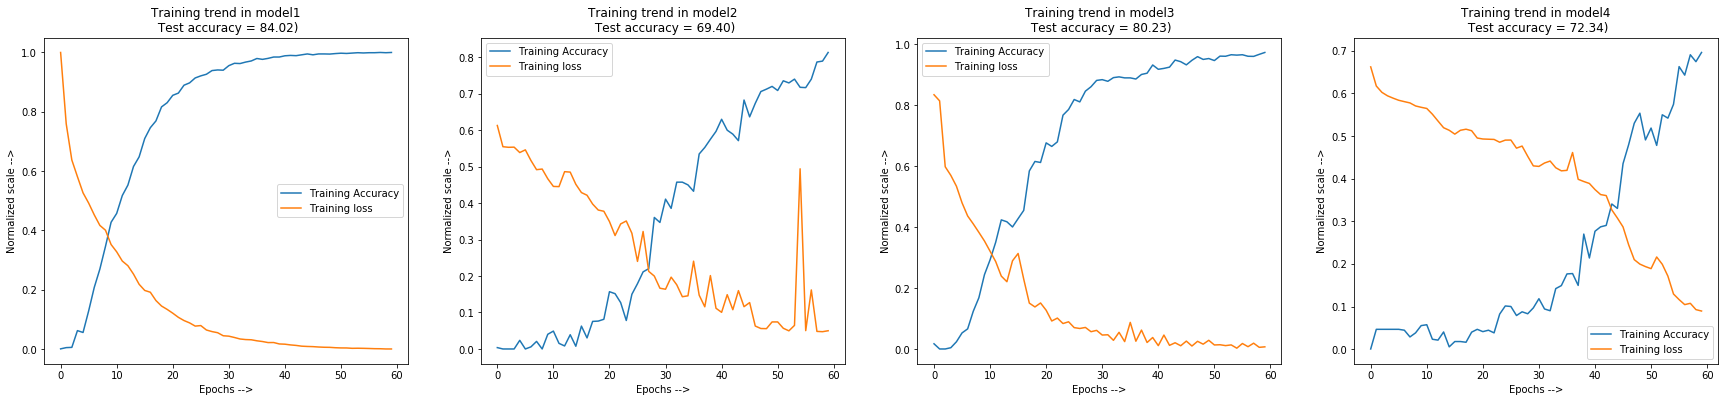

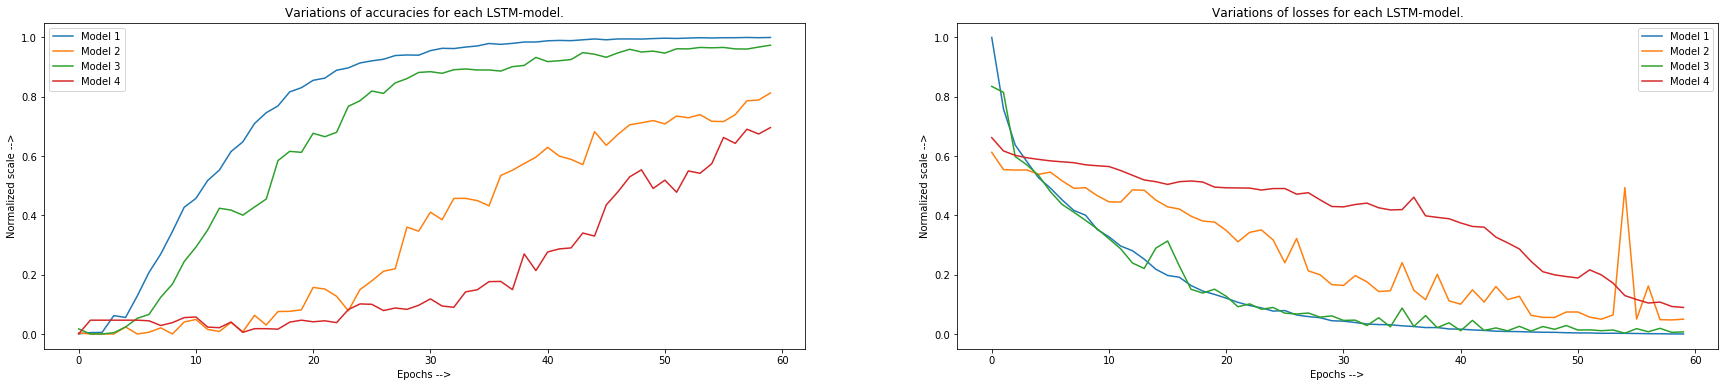

In [0]:
"""
Analysing trends of loss and accuracy for each executed model
"""
import matplotlib.pyplot as plt

def normalize_logs(data):
  return (data-data.min())/(data.max()-data.min())

all_acc = np.array( acc1 + acc2 + acc3 + acc4 )
all_loss = np.array(loss1 + loss2 + loss3 + loss4)

all_acc = (all_acc-all_acc.min())/(all_acc.max() - all_acc.min())
all_loss = (all_loss-all_loss.min())/(all_loss.max()-all_loss.min())

all_acc = normalize_logs(all_acc).reshape(4,-1)
all_loss = normalize_logs(all_loss).reshape(4,-1)

f1 = plt.figure(figsize=(30,6))

f1.add_subplot(1,4,1)
plt.title("Training trend in model1\n Test accuracy = {:.2f})".format(test_accuracy1))
plt.plot(all_acc[0], label="Training Accuracy")
plt.plot(all_loss[0], label="Training loss")
plt.xlabel("Epochs -->")
plt.ylabel("Normalized scale -->")
plt.legend()

f1.add_subplot(1,4,2)
plt.title("Training trend in model2\n Test accuracy = {:.2f})".format(test_accuracy2))
plt.plot(all_acc[1], label="Training Accuracy")
plt.plot(all_loss[1], label="Training loss")
plt.xlabel("Epochs -->")
plt.ylabel("Normalized scale -->")
plt.legend()

f1.add_subplot(1,4, 3)
plt.title("Training trend in model3\n Test accuracy = {:.2f})".format(test_accuracy3))
plt.plot(all_acc[2], label="Training Accuracy")
plt.plot(all_loss[2], label="Training loss")
plt.xlabel("Epochs -->")
plt.ylabel("Normalized scale -->")
plt.legend()

f1.add_subplot(1,4, 4)
plt.title("Training trend in model4\n Test accuracy = {:.2f})".format(test_accuracy4))
plt.plot(all_acc[3], label="Training Accuracy")
plt.plot(all_loss[3], label="Training loss")
plt.xlabel("Epochs -->")
plt.ylabel("Normalized scale -->")
plt.legend()

f2 = plt.figure(figsize=(30,6))

f2.add_subplot(1,2,1)
plt.title("Variations of accuracies for each LSTM-model.")
plt.plot(all_acc[0], label="Model 1")
plt.plot(all_acc[1], label="Model 2")
plt.plot(all_acc[2], label="Model 3")
plt.plot(all_acc[3], label="Model 4")
plt.xlabel("Epochs -->")
plt.ylabel("Normalized scale -->")
plt.legend()

f2.add_subplot(1,2,2)
plt.title("Variations of losses for each LSTM-model.")
plt.plot(all_loss[0], label="Model 1")
plt.plot(all_loss[1], label="Model 2")
plt.plot(all_loss[2], label="Model 3")
plt.plot(all_loss[3], label="Model 4")
plt.xlabel("Epochs -->")
plt.ylabel("Normalized scale -->")
plt.legend()

plt.show(block=True)

## **Problem 4.** Report

## **Bonus**


* ##### **Print the size of your training and test data**

In [0]:
"""
Extracting the features for entrire dataset.
"""

last_train_batch = feat_extractor(list(zip(train_video_titles, train_video_labels)), 0)
last_test_batch = feat_extractor(list(zip(test_video_titles, test_video_labels)), last_train_batch+1)

 998 / 9537
features_0.pkl created successfully!
 1998 / 9537
features_1.pkl created successfully!
 2998 / 9537
features_2.pkl created successfully!
 3998 / 9537
features_3.pkl created successfully!
 4998 / 9537
features_4.pkl created successfully!
 5998 / 9537
features_5.pkl created successfully!
 6998 / 9537
features_6.pkl created successfully!
 7998 / 9537
features_7.pkl created successfully!
 8998 / 9537
features_8.pkl created successfully!
 9536 / 9537
features_9.pkl created successfully!
 998 / 3783
features_10.pkl created successfully!
 1998 / 3783
features_11.pkl created successfully!
 2998 / 3783
features_12.pkl created successfully!
 3782 / 3783
features_13.pkl created successfully!


In [0]:
"""
Reading the extracted features saved in pickle files (in batches of 1000 videos).
"""

train_features_full, train_titles_full, train_labels_full = reader(list(range(0,10)))
test_features_full, test_titles_full, test_labels_full = reader(list(range(10, 14)))

Reading features_0.pkl
Reading features_1.pkl
Reading features_2.pkl
Reading features_3.pkl
Reading features_4.pkl
Reading features_5.pkl
Reading features_6.pkl
Reading features_7.pkl
Reading features_8.pkl
Reading features_9.pkl
Reading features_10.pkl
Reading features_11.pkl
Reading features_12.pkl
Reading features_13.pkl


In [0]:
# Don't hardcode the shape of train and test data
print('Shape of training data is : {}'.format(train_features_full.shape))
print('Shape of test/validation data is : {}'.format(test_features_full.shape))

Shape of training data is : torch.Size([9537, 25, 4096])
Shape of test/validation data is : torch.Size([3783, 25, 4096])


* ##### **Modelling and evaluation**

In [0]:
#Write your code for modelling and evaluation
class RNNmodelX(nn.Module):
  def __init__(self):
    super(RNNmodelX, self).__init__()
    self.layer1 = nn.LSTM(4096, 1024)
    self.logits = nn.Linear(1024, 101)

  def forward(self, x):
    outputs, _ = self.layer1(x)
    outputs = self.logits(outputs[:,-1])
    return outputs

## Training Model 1
netx = RNNmodelX()
loss_fn = nn.CrossEntropyLoss()
epochs = 170
optimizer = optim.Adam(netx.parameters())
accx, lossx, train_timex = train_network(netx, loss_fn, train_features_full, train_labels_full, epochs, optimizer)

GPU enabled training = True
Epoch = 1,	Loss = 7.6705,	Training accuracy = 0.0105
Epoch = 2,	Loss = 6.0388,	Training accuracy = 1.1744
Epoch = 3,	Loss = 5.6696,	Training accuracy = 0.0315
Epoch = 4,	Loss = 5.8138,	Training accuracy = 0.0419
Epoch = 5,	Loss = 5.7798,	Training accuracy = 0.0734
Epoch = 6,	Loss = 5.3702,	Training accuracy = 0.0419
Epoch = 7,	Loss = 5.3157,	Training accuracy = 0.0734
Epoch = 8,	Loss = 5.6432,	Training accuracy = 0.0315
Epoch = 9,	Loss = 5.6657,	Training accuracy = 0.0210
Epoch = 10,	Loss = 5.5072,	Training accuracy = 0.0000
Epoch = 11,	Loss = 5.0475,	Training accuracy = 0.0000
Epoch = 12,	Loss = 5.3289,	Training accuracy = 0.0000
Epoch = 13,	Loss = 5.2173,	Training accuracy = 0.4089
Epoch = 14,	Loss = 5.1276,	Training accuracy = 0.0000
Epoch = 15,	Loss = 4.7484,	Training accuracy = 0.7654
Epoch = 16,	Loss = 4.7124,	Training accuracy = 0.8074
Epoch = 17,	Loss = 4.9774,	Training accuracy = 0.8913
Epoch = 18,	Loss = 4.6266,	Training accuracy = 2.5165
Epoch = 1

In [0]:
test_accuracyX, eval_timeX = evaluate_model(netx, test_features_full, test_labels_full)

In [32]:
print("Test accuracy on complete data is {} with training time = {} seconds".format(test_accuracyX, train_timex))

Test accuracy on complete data is 64.31403647898493 with training time = 1038.96 seconds


## Submission
---
**Runnable source code in ipynb file and a pdf report are required**.

The report should be of 3 to 4 pages describing what you have done and learned in this homework and report performance of your model. If you have tried multiple methods, please compare your results. If you are using any external code, please cite it in your report. Note that this homework is designed to help you explore and get familiar with the techniques. The final grading will be largely based on your prediction accuracy and the different methods you tried (different architectures and parameters).

Please indicate clearly in your report what model you have tried, what techniques you applied to improve the performance and report their accuracies. The report should be concise and include the highlights of your efforts.
The naming convention for report is **Surname_Givenname_SBUID_report*.pdf**

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.pdf
        |---Surname_Givenname_SBUID_report*.pdf
```

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw5.zip" for homework5 in this structure:
```
Jordan_Michael_111134567_hw5
        |---Jordan_Michael_111134567_hw5.ipynb
        |---Jordan_Michael_111134567_hw5.pdf
        |---Jordan_Michael_111134567_report*.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link**. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. 

Then right click this folder, click ***Get shareable link***, in the People textfield, enter two TA's emails: ***bo.cao.1@stonybrook.edu*** and ***sayontan.ghosh@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.